In [100]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 5)

pd.set_option("display.max_columns", None)


In [101]:
DATA_PATH = ""

dim_blocks = pd.read_csv(DATA_PATH + "dim_blocks_v1.csv", encoding='latin1')
fact_stores = pd.read_csv(DATA_PATH + "fact_stores_v1.csv", encoding='latin1')
fact_malls = pd.read_csv(DATA_PATH + "fact_malls_v1.csv", encoding='latin1')
store_financials = pd.read_csv(DATA_PATH + "store_financials_v1.csv", encoding='latin1')
cross_visits = pd.read_csv(DATA_PATH + "cross_visits_v1.csv", encoding='latin1')
sri_scores = pd.read_csv(DATA_PATH + "fact_sri_scores_v1.csv", encoding='latin1')
dim_malls = pd.read_csv(DATA_PATH + "dim_malls_v1.csv", encoding='latin1')

print("All datasets loaded successfully.")

All datasets loaded successfully.


### Visualization of the most frequent cross-visit paths


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_92743/3027017702.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


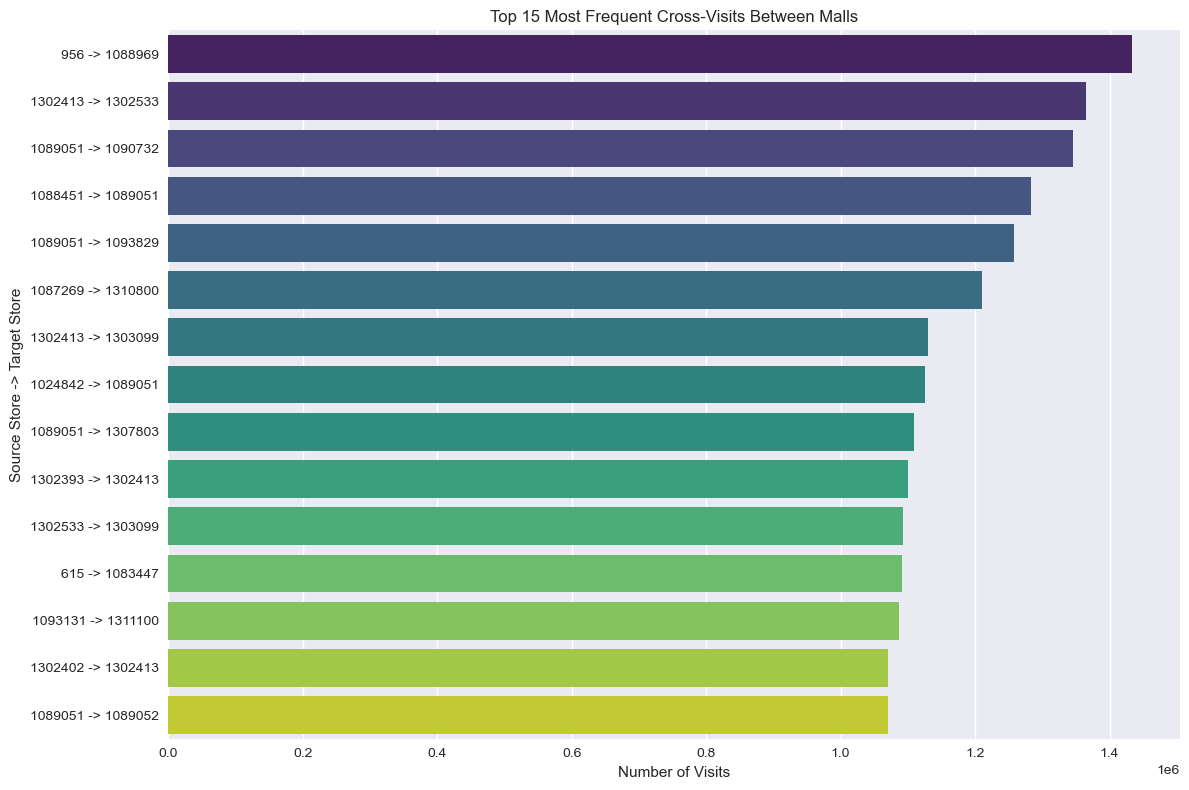

Top 10 most frequent cross-visits between malls:


,store_code_1,store_code_2,visit_count
6497,956,1088969,1433132
235929,1302413,1302533,1365018
161989,1089051,1090732,1344999
159868,1088451,1089051,1283772
161993,1089051,1093829,1258417
158022,1087269,1310800,1209731
235938,1302413,1303099,1129769
75216,1024842,1089051,1125551
162046,1089051,1307803,1109495
234600,1302393,1302413,1100875


In [102]:
cross_visits_grouped = (
    cross_visits
    .groupby(['store_code_1', 'store_code_2'])['total_cross_visits']
    .sum() # Summing the existing total_cross_visits instead of counting rows
    .reset_index(name='visit_count')
)

cross_visits_sorted = (
    cross_visits_grouped
    .sort_values(by='visit_count', ascending=False)
)

# Get the top N frequent cross-visits for visualization
N = 15 # can adjust N as needed
top_n_cross_visits = cross_visits_sorted.head(N)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_n_cross_visits,
    x='visit_count',
    y=top_n_cross_visits['store_code_1'].astype(str) + ' -> ' + top_n_cross_visits['store_code_2'].astype(str),
    palette='viridis'
)
plt.title(f'Top {N} Most Frequent Cross-Visits Between Malls')
plt.xlabel('Number of Visits')
plt.ylabel('Source Store -> Target Store')
plt.tight_layout()
plt.show()

print("Top 10 most frequent cross-visits between malls:")
display(cross_visits_sorted.head(10))

### Analysis of cross-visits between store categories (BL1)

In [103]:
# Merge cross_visits with dim_blocks to get bl1_label for store_code_1
cross_visits_with_categories = pd.merge(
    cross_visits,
    dim_blocks[['store_code', 'bl1_label']],
    left_on='store_code_1',
    right_on='store_code',
    how='left',
    suffixes=('_1', None)
).rename(columns={'bl1_label': 'bl1_label_1', 'store_code': 'store_code_dim_1'})

# Merge again to get bl1_label for store_code_2
cross_visits_with_categories = pd.merge(
    cross_visits_with_categories,
    dim_blocks[['store_code', 'bl1_label']],
    left_on='store_code_2',
    right_on='store_code',
    how='left',
    suffixes=('_2', None)
).rename(columns={'bl1_label': 'bl1_label_2', 'store_code': 'store_code_dim_2'})

# Drop redundant store_code columns from dim_blocks
cross_visits_with_categories = cross_visits_with_categories.drop(columns=['store_code_dim_1', 'store_code_dim_2'])

print("Shape of cross_visits_with_categories DataFrame:", cross_visits_with_categories.shape)
display(cross_visits_with_categories.head())

Shape of cross_visits_with_categories DataFrame: (338086, 5)


,store_code_1,store_code_2,total_cross_visits,bl1_label_1,bl1_label_2
0,956,1088969,1433132,Fashion apparel,Fashion apparel
1,956,1088969,1433132,Fashion apparel,Fashion apparel
2,1302413,1302533,1365018,Fashion apparel,Fashion apparel
3,1089051,1090732,1344999,Fashion apparel,Fashion apparel
4,1088451,1089051,1283772,Fashion apparel,Fashion apparel


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_92743/1775637422.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


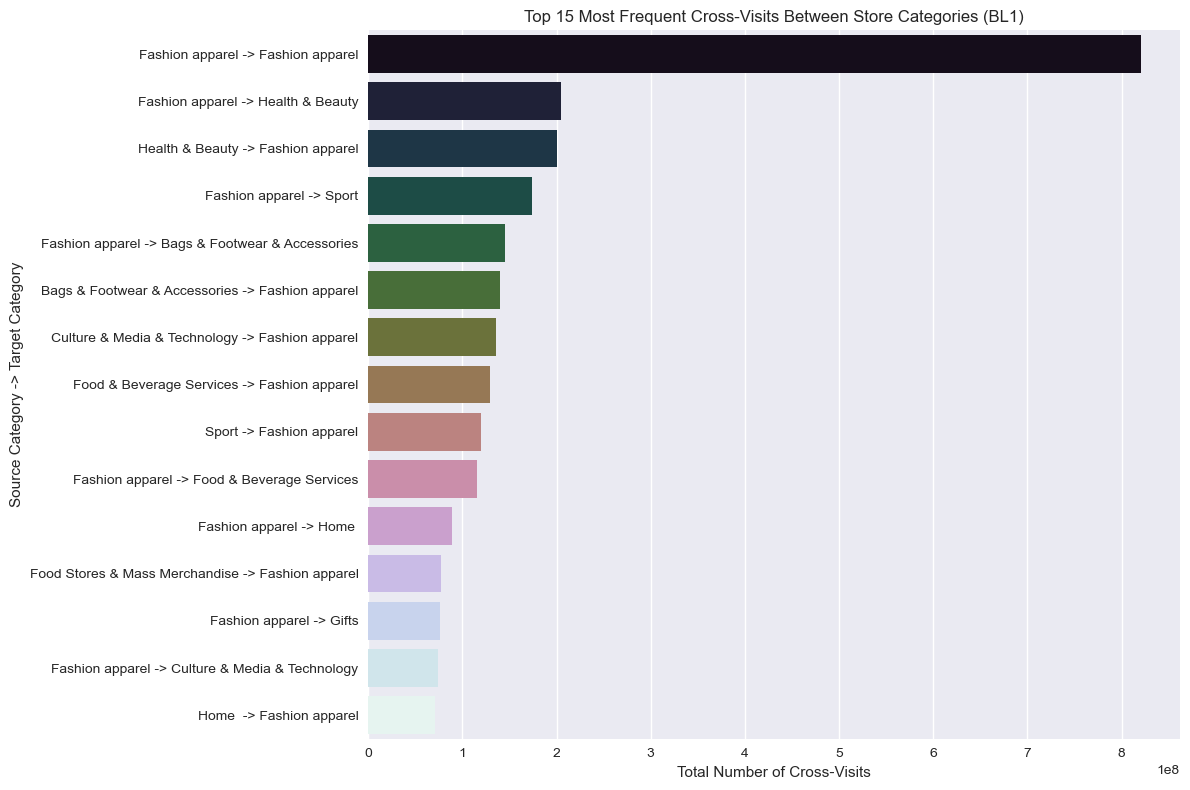

Top 10 most frequent cross-visits between store categories (BL1):


,bl1_label_1,bl1_label_2,total_category_cross_visits
93,Fashion apparel,Fashion apparel,821059344
98,Fashion apparel,Health & Beauty,204884614
183,Health & Beauty,Fashion apparel,199954115
105,Fashion apparel,Sport,173502158
89,Fashion apparel,Bags & Footwear & Accessories,144757736
21,Bags & Footwear & Accessories,Fashion apparel,139755695
39,Culture & Media & Technology,Fashion apparel,135221202
129,Food & Beverage Services,Fashion apparel,128773858
303,Sport,Fashion apparel,120137376
95,Fashion apparel,Food & Beverage Services,115046601


In [104]:
# Aggregate cross-visits by bl1_label pairs
category_cross_visits_grouped = (
    cross_visits_with_categories
    .groupby(['bl1_label_1', 'bl1_label_2'])['total_cross_visits']
    .sum()
    .reset_index(name='total_category_cross_visits')
)

# Sort by total_category_cross_visits
category_cross_visits_sorted = (
    category_cross_visits_grouped
    .sort_values(by='total_category_cross_visits', ascending=False)
)

# Get the top N frequent category cross-visits for visualization
N_categories = 15 # You can adjust N_categories as needed
top_n_category_cross_visits = category_cross_visits_sorted.head(N_categories)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_n_category_cross_visits,
    x='total_category_cross_visits',
    y=top_n_category_cross_visits['bl1_label_1'].astype(str) + ' -> ' + top_n_category_cross_visits['bl1_label_2'].astype(str),
    palette='cubehelix'
)
plt.title(f'Top {N_categories} Most Frequent Cross-Visits Between Store Categories (BL1)')
plt.xlabel('Total Number of Cross-Visits')
plt.ylabel('Source Category -> Target Category')
plt.tight_layout()
plt.show()

print("Top 10 most frequent cross-visits between store categories (BL1):")
display(category_cross_visits_sorted.head(10))

i should normalize so that there is no size bias

entre malls : pas utile

### Analysis of financial performance by store category


In [105]:
store_financials_with_dims = (
    store_financials
    .merge(dim_blocks, left_on="codstr", right_on="store_code", how="left")
)

print("Shape of joined DataFrame:", store_financials_with_dims.shape)
display(store_financials_with_dims.head())

Shape of joined DataFrame: (12463, 15)


,codstr,cur_code,sales_r12m,total_costs_r12m,mall_id,block_id,block_type,store_code,store_name,retailer_code,bl1_label,bl2_label,bl3_label,gla,gla_category
0,10,EUR,465074.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42,EUR,894103.049,180566.23130,16.0,1805.0,CELL,42.0,NaN,502.0,Food & Beverage Services,Fast Meal,American & Burgers,1117.0,MSU
2,97,EUR,314785.856,57236.11960,16.0,1672.0,CELL,97.0,NaN,3401.0,Fashion apparel,Men's Fashion,Men's Fashion,144.0,SMALL UNITS
3,111,EUR,142445.451,58707.57464,16.0,1772.0,CELL,111.0,NaN,217.0,Fashion apparel,Women's Fashion,Women's Fashion,176.0,SMALL UNITS
4,116,EUR,163417.125,36280.75528,16.0,1782.0,CELL,116.0,NaN,422.0,Health & Beauty,Hair & Body,Hairdressers,193.0,SMALL UNITS


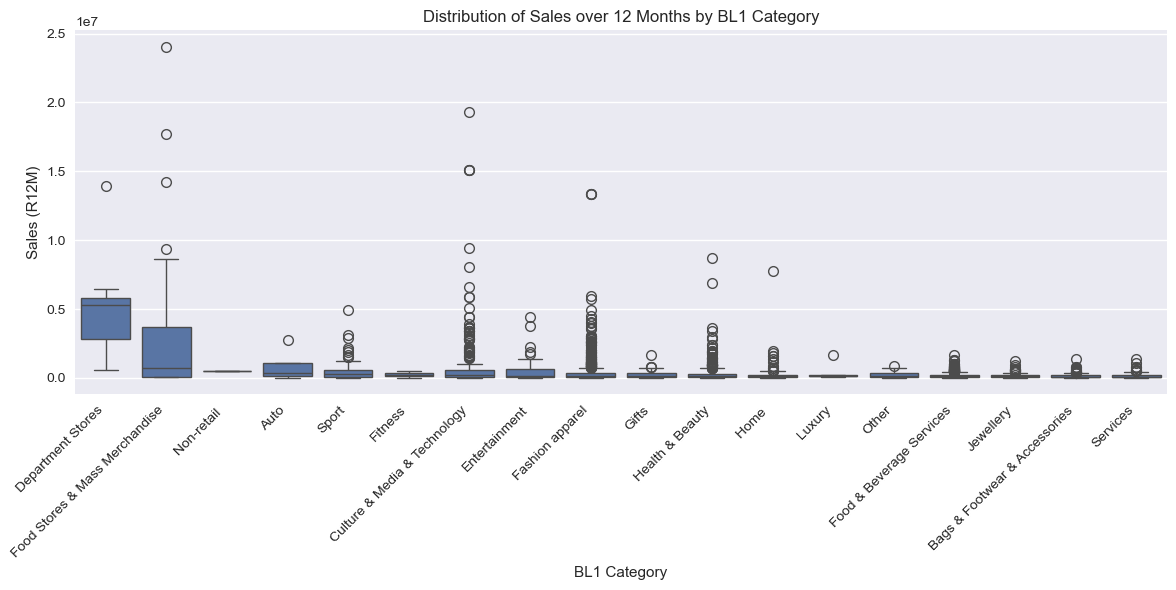

In [106]:
store_financials_with_dims['sales_r12m'] = pd.to_numeric(store_financials_with_dims['sales_r12m'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=store_financials_with_dims,
    x="bl1_label",
    y="sales_r12m",
    order=store_financials_with_dims.groupby("bl1_label")["sales_r12m"].median().sort_values(ascending=False).index
)
plt.title("Distribution of Sales over 12 Months by BL1 Category")
plt.xlabel("BL1 Category")
plt.ylabel("Sales (R12M)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Analysis of shopping center footfall on a weekly basis


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_92743/42553049.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fact_malls['date'] = pd.to_datetime(fact_malls['date'])


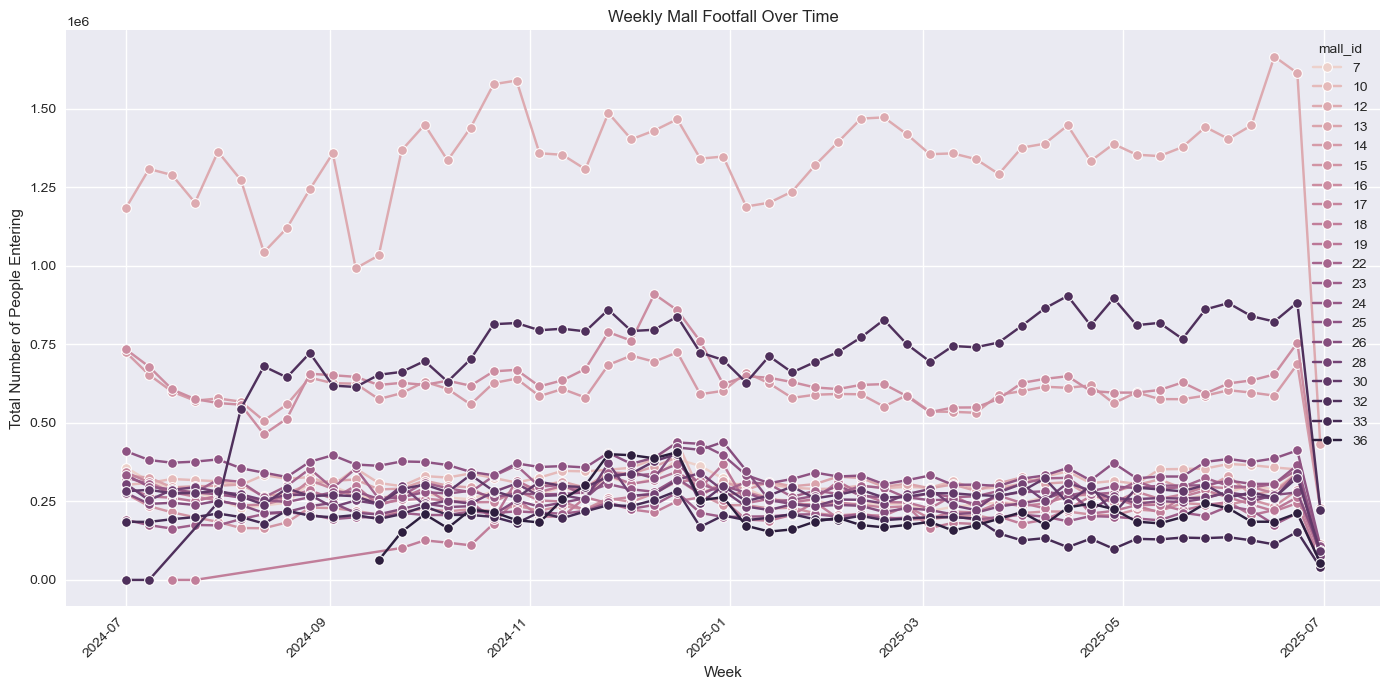

In [107]:
fact_malls['date'] = pd.to_datetime(fact_malls['date'])
fact_malls['week'] = fact_malls['date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_mall_footfall = fact_malls.groupby(['mall_id', 'week'])['people_in'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=weekly_mall_footfall,
    x='week',
    y='people_in',
    hue='mall_id',
    marker='o',
    legend='full'
)
plt.title('Weekly Mall Footfall Over Time')
plt.xlabel('Week')
plt.ylabel('Total Number of People Entering')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Spatial Analysis Strategy (Proposed)

Following discussions with Mr. Bairagi, a spatial analysis approach is proposed to enhance the retail mix optimization:

1.  **Position on Account:**
    *   **Distance from Entrance:** Stores closer to entrances may have higher natural footfall.
    *   **Distance between Shops:** Crucial for understanding cross-selling potential (synergy between neighbors).

2.  **Implementation Plan:**
    *   **Digitize/Rasterize Mall Maps:** Process the provided PDF plans (e.g., Vélizy 2, Parly 2, Euralille) onto a coordinate system.
    *   **Polygon Definition:** Define each shop unit as a polygon (e.g., `POLYGON((x1,y1), (x2,y2), ...)`).
    *   **Barycenter Calculation:** Compute the geometric center (centroid/barycenter) for each shop polygon.
    *   **Distance Metrics:** Use the distances between centroids as a proxy for physical proximity to correlate with cross-visit data.



In [110]:

def calculate_shop_centroid(polygon_coords):
    if not polygon_coords:
        return None
    x_coords = [p[0] for p in polygon_coords]
    y_coords = [p[1] for p in polygon_coords]
    centroid_x = sum(x_coords) / len(x_coords)
    centroid_y = sum(y_coords) / len(y_coords)
    return (centroid_x, centroid_y)

def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

print("Spatial Analysis functions defined (Placeholders for future map digitization).")



Spatial Analysis functions defined (Placeholders for future map digitization).


In [111]:

# --- Data Cleaning & Type Conversion ---

store_financials['sales_r12m'] = pd.to_numeric(store_financials['sales_r12m'], errors='coerce')

dim_blocks['gla'] = pd.to_numeric(dim_blocks['gla'], errors='coerce')

print("Data types converted. Missing/Invalid values set to NaN.")



Data types converted. Missing/Invalid values set to NaN.


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_92743/1747601296.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_density_by_category, x='sales_density', y='bl1_label', palette='magma')


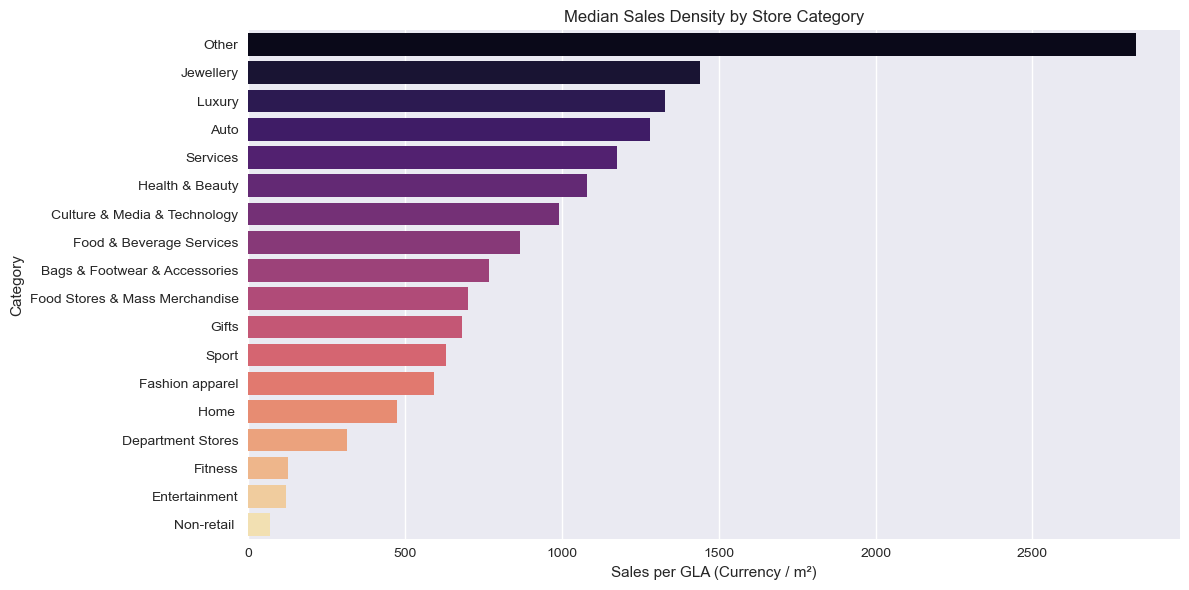

Top 5 Categories by Sales Density:


,bl1_label,sales_density
0,Other,2828.929773
1,Jewellery,1439.018087
2,Luxury,1329.218562
3,Auto,1280.289397
4,Services,1175.468068


In [112]:

# --- Deepening EDA: Sales Density Analysis ---

store_performance = pd.merge(store_financials, dim_blocks, left_on='codstr', right_on='store_code', how='left')

store_performance = store_performance[store_performance['gla'] > 0]
store_performance['sales_density'] = store_performance['sales_r12m'] / store_performance['gla']

sales_density_by_category = store_performance.groupby('bl1_label')['sales_density'].median().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=sales_density_by_category, x='sales_density', y='bl1_label', palette='magma')
plt.title('Median Sales Density by Store Category')
plt.xlabel('Sales per GLA (Currency / m²)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

print("Top 5 Categories by Sales Density:")
display(sales_density_by_category.head(5))



/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_92743/2336825282.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=capture_rate_by_category, x='capture_rate', y='bl1_label', palette='coolwarm')


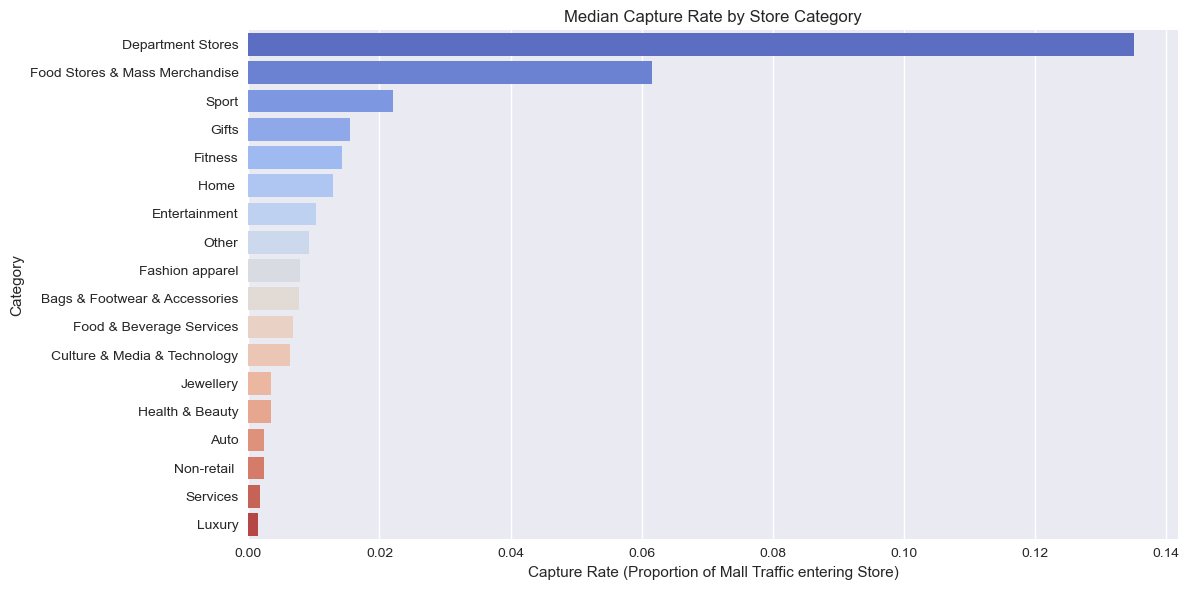

Top 5 Categories by Capture Rate:


,bl1_label,capture_rate
0,Department Stores,0.135062
1,Food Stores & Mass Merchandise,0.061605
2,Sport,0.022004
3,Gifts,0.015490
4,Fitness,0.014269


In [113]:

# --- Deepening EDA: Capture Rate Analysis ---

store_traffic_total = fact_stores.groupby(['store_code', 'mall_id'])['people_in'].sum().reset_index()

mall_traffic_total = fact_malls.groupby('mall_id')['people_in'].sum().reset_index().rename(columns={'people_in': 'total_mall_traffic'})

capture_rate_df = pd.merge(store_traffic_total, mall_traffic_total, on='mall_id', how='left')

capture_rate_df['capture_rate'] = capture_rate_df['people_in'] / capture_rate_df['total_mall_traffic']

capture_rate_df = pd.merge(capture_rate_df, dim_blocks[['store_code', 'bl1_label']], on='store_code', how='left')

capture_rate_by_category = capture_rate_df.groupby('bl1_label')['capture_rate'].median().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=capture_rate_by_category, x='capture_rate', y='bl1_label', palette='coolwarm')
plt.title('Median Capture Rate by Store Category')
plt.xlabel('Capture Rate (Proportion of Mall Traffic entering Store)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

print("Top 5 Categories by Capture Rate:")
display(capture_rate_by_category.head(5))



Loaded spatial data for 134 stores.
Pairwise Distance Matrix Shape: (134, 134)


store_code,123DM,127BM,170AM,621 m2,100
store_code,,,,,
123DM,0.000000,125.334793,452.613699,685.279971,685.279971
127BM,125.334793,0.000000,328.924232,806.156604,806.156604
170AM,452.613699,328.924232,0.000000,1112.944597,1112.944597
621 m2,685.279971,806.156604,1112.944597,0.000000,0.000000
100,685.279971,806.156604,1112.944597,0.000000,0.000000


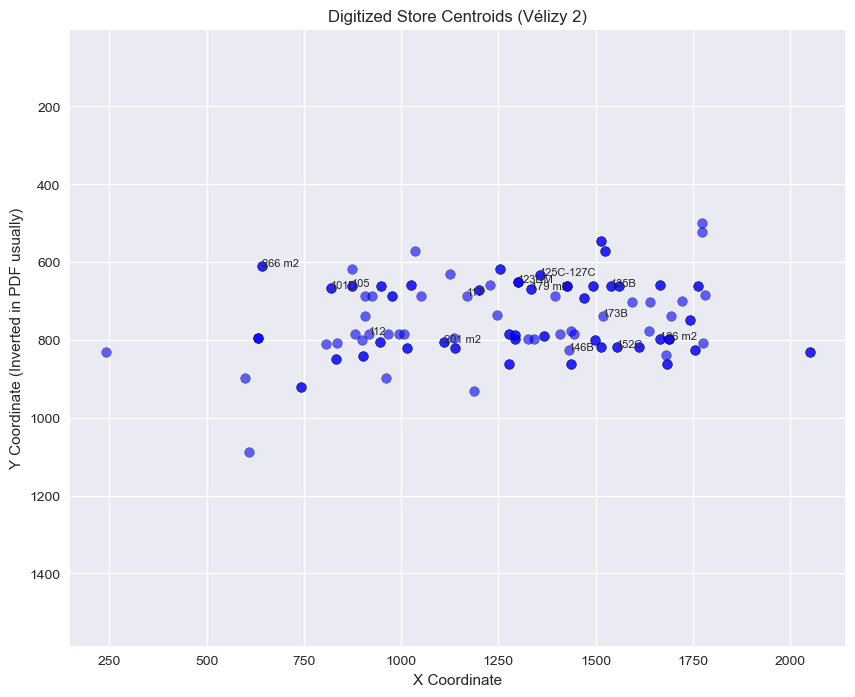

In [115]:

# --- Spatial Analysis: Distance Matrix Calculation ---

spatial_df = pd.read_csv('extracted_store_coordinates_v2.csv')
print(f"Loaded spatial data for {len(spatial_df)} stores.")

from scipy.spatial.distance import pdist, squareform

coords = spatial_df[['barycenter_x', 'barycenter_y']].values

dist_condensed = pdist(coords, metric='euclidean')
dist_matrix = squareform(dist_condensed)

dist_df = pd.DataFrame(dist_matrix, index=spatial_df['store_code'], columns=spatial_df['store_code'])

print("Pairwise Distance Matrix Shape:", dist_df.shape)
display(dist_df.iloc[:5, :5]) # Show subset

plt.figure(figsize=(10, 8))
plt.scatter(spatial_df['barycenter_x'], spatial_df['barycenter_y'], alpha=0.6, c='blue', edgecolors='k')
for i, txt in enumerate(spatial_df['store_code']):
    if i % 10 == 0: 
        plt.annotate(txt, (spatial_df.barycenter_x[i], spatial_df.barycenter_y[i]), fontsize=8)
plt.title('Digitized Store Centroids (Vélizy 2)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate (Inverted in PDF usually)')
plt.gca().invert_yaxis() # PDF coords often have 0 at top-left
plt.axis('equal')
plt.show()



## Geometry Extraction

Using `pymupdf` to extract vector paths and text labels from PDF plans.


In [116]:
!pip install pymupdf



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [117]:

import fitz
import re
import os
import pandas as pd

def extract_from_single_pdf(pdf_path):
    # Parses a PDF plan to find store units.
    try:
        doc = fitz.open(pdf_path)
    except Exception:
        return []

    store_data = []

    for page_num in range(min(3, len(doc))):
        page = doc[page_num]
        text_instances = page.get_text("blocks")
        paths = page.get_drawings()
        
        candidate_polys = []
        for p in paths:
            if p['rect'].width > 5 and p['rect'].height > 5:
                candidate_polys.append(p['rect'])

        code_pattern = re.compile(r'\b\d+[A-Z]+\b|\b[A-Z]{1,2}\d+\b|\b\d{3,}\b') 

        for t in text_instances:
            text_content = t[4].strip()
            
            lines = text_content.split('\n')
            for line in lines:
                line = line.strip()
                if code_pattern.search(line) and len(line) < 10:
                    store_code = line
                    
                    tx0, ty0, tx1, ty1 = t[0], t[1], t[2], t[3]
                    t_center_x = (tx0 + tx1) / 2
                    t_center_y = (ty0 + ty1) / 2
                    
                    best_container = None
                    min_area = float('inf')
                    
                    for poly_rect in candidate_polys:
                        if (poly_rect.x0 <= t_center_x <= poly_rect.x1) and \
                           (poly_rect.y0 <= t_center_y <= poly_rect.y1):
                            area = poly_rect.width * poly_rect.height
                            if area < min_area:
                                min_area = area
                                best_container = poly_rect
                    
                    if best_container:
                        bary_x = (best_container.x0 + best_container.x1) / 2
                        bary_y = (best_container.y0 + best_container.y1) / 2
                        
                        mall_name = os.path.basename(pdf_path).replace(" - Plan.pdf", "").replace("Westfield ", "")

                        store_data.append({
                            'mall_name': mall_name,
                            'store_code': store_code,
                            'barycenter_x': bary_x,
                            'barycenter_y': bary_y,
                            'page': page_num
                        })
                        break 
    return store_data

print("Extraction function defined.")



Extraction function defined.


Loaded consolidated spatial data.


,mall_name,Store Count
0,Euralille,259
1,Parly 2,358
2,Vélizy 2,374


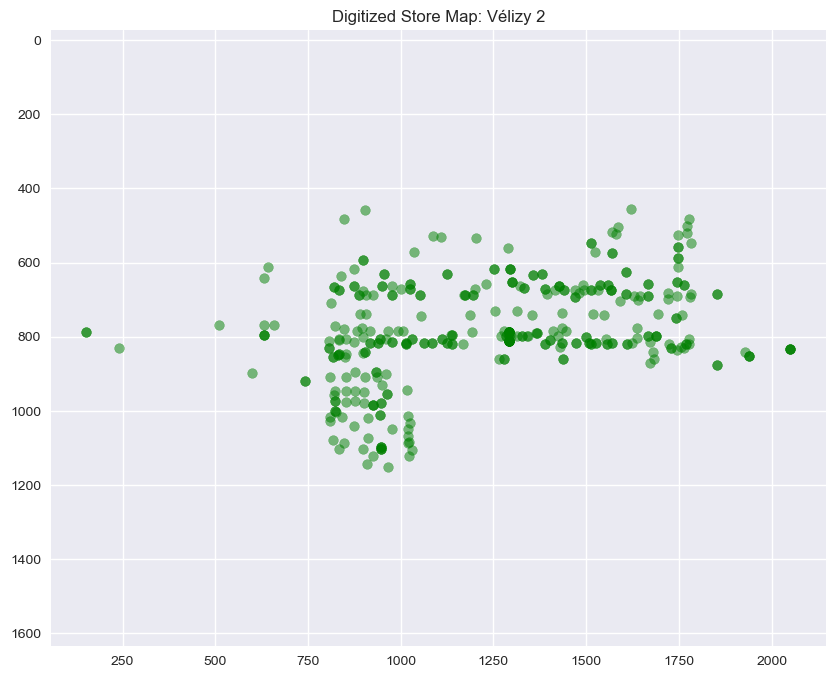

CSV 'all_malls_coordinates.csv' not found. Please run extraction logic.


In [118]:

# --- Load Extracted Data for All Malls ---

all_malls_df = pd.read_csv('all_malls_coordinates.csv')
print("Loaded consolidated spatial data.")
display(all_malls_df.groupby('mall_name').size().reset_index(name='Store Count'))

target_mall = 'Vélizy 2'
mall_data = all_malls_df[all_malls_df['mall_name'] == target_mall]

if not mall_data.empty:
        plt.figure(figsize=(10, 8))
        plt.scatter(mall_data['barycenter_x'], mall_data['barycenter_y'], alpha=0.5, c='green')
        plt.title(f'Digitized Store Map: {target_mall}')
        plt.gca().invert_yaxis()
        plt.axis('equal')
        plt.show()
        
print("CSV 'all_malls_coordinates.csv' not found. Please run extraction logic.")

